In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from datetime import date
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import resample
from xgboost import XGBClassifier
import os
import json

path = '/content/drive/MyDrive/TFG ICO/Notebooks/Tables/'

***
# Useful functions

In [5]:
def plot_roc_curve(y_test, y_pred_prob):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    plt.plot(fpr, tpr, linewidth=2, label=None)
    plt.plot([0, 1], [0, 1], 'k--') # Dashed diagonal
    plt.grid(True)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.show()

36 months
=== Training set: 
3082 patients -- 27.5% dead 

=== After upsample: 
4470 patients -- 50.0% dead
=== After upsample: 
4470 patients -- 50.0% dead
=== After upsample: 
4470 patients -- 50.0% dead


In [6]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [7]:
def main(months):
    ## Load the data
    df_test = pd.read_csv(path + f'df_test_{months}.csv')
    X_test = df_test.loc[:, df_test.columns != 'is_dead']
    y_test = df_test['is_dead']

    df_train = pd.read_csv(path + f'df_train_{months}.csv')
    X_train = df_train.loc[:, df_train.columns != 'is_dead']
    y_train = df_train['is_dead']
    print(months, 'months')
    print('=== Training set: \n{} patients -- {}% dead \n'.format(len(df_train), round(100*df_train.is_dead.mean(), 1)))

    ## The chosen algorithm is XGB, no scaling is neeeded
    
    ## Fill missing values with zeros
    X_train = X_train.fillna(0)
    X_test = X_test.fillna(0)

        
    ## Upsampling
    df_train = X_train.copy()
    df_train['is_dead'] = y_train.copy()
    # Separate minority and majority
    df_dead = df_train[df_train.is_dead == 1.]
    df_alive = df_train[df_train.is_dead == 0.]
    # Upsampling the minority
    df_dead_upsampled = resample(df_dead, replace=True, n_samples=len(df_alive), random_state=0)
    # New training set
    df_upsampled = pd.concat([df_alive, df_dead_upsampled])
    X_train = df_upsampled.loc[:, df_upsampled.columns != 'is_dead']
    y_train = df_upsampled['is_dead']


    start = time.time()

    X = X_train.copy()
    y = y_train.copy()

    ### Grid search with cross-validation   
    hyperparams = [
        {
            'n_estimators':[50, 100, 250, 500, 750], 
            'max_depth':[2, 3, 5, 10, 15, 20, 25, 30, 40, 60],
        }
    ]
    gs = GridSearchCV(
        XGBClassifier(random_state=0), 
        hyperparams,
        cv=5, 
        scoring=['roc_auc','f1','accuracy', 'precision', 'recall'], 
        refit = False
    )
    gs.fit(X, y)    
    df_cv_results = pd.DataFrame(gs.cv_results_)
    df_cv_results['model'] = 'xgb'
    
    end = time.time()
    duration = end - start
    if duration > 3600:
      duration = duration/3600
      unit = 'hours'
    elif duration > 60:
      duration = duration/60
      unit = 'minutes'
    else:
      unit = 'seconds'
    print('Fitted in {} {}'.format(round(duration, 1), unit))

    cols_to_show = ['model', 'params', 'mean_test_roc_auc', 'mean_test_f1', 'mean_test_precision', 'mean_test_recall']
    df_results = df_cv_results[cols_to_show].round(3)
    df_results = df_results.sort_values(by=['mean_test_roc_auc', 'mean_test_f1'], ascending=False)

    df_results.to_csv(path + f'fit_results_{months}.csv', index=False)



    best_result_alg = df_results.iloc[0]
    print('Metrics from cross-validation')
    print(best_result_alg)
    best_hyperparameters = best_result_alg['params']
    print('Best hyperparameters:', best_hyperparameters)

    # Select and train the best estimator
    model = XGBClassifier(random_state=0).set_params(**best_hyperparameters)
    model.fit(X, y)

    #Make predictions on the test set
    y_pred = model.predict(X_test)
    print('Predicted', sum(y_pred), 'deaths out of', len(y_pred), 'patients ({}%)'.format(round(100*sum(y_pred)/len(y_pred),1)))

    y_pred_prob = model.predict_proba(X_test)[:, 1]
    print('Min prob:', round(min(y_pred_prob), 3))
    print('Max prob:', round(max(y_pred_prob), 3))

    plot_roc_curve(y_test, y_pred_prob)

    ## Metrics
    print('Metrics on the test set')
    print(round(roc_auc_score(y_test, y_pred_prob), 3))
    print(round(f1_score(y_test, y_pred), 3))
    print(round(accuracy_score(y_test, y_pred), 3))
    print(round(precision_score(y_test, y_pred), 3))
    print(round(recall_score(y_test, y_pred), 3))



12 months
=== Training set: 
5105 patients -- 6.4% dead 

Fitted in 1.3 hours
model                                                     xgb
params                 {'max_depth': 15, 'n_estimators': 750}
mean_test_roc_auc                                       0.998
mean_test_f1                                            0.993
mean_test_precision                                     0.986
mean_test_recall                                            1
Name: 24, dtype: object
Best hyperparameters: {'max_depth': 15, 'n_estimators': 750}
Predicted 50.0 deaths out of 902 patients (5.5%)
Min prob: 0.0
Max prob: 1.0


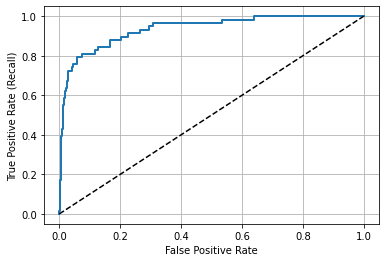

0.935
0.63
0.956
0.68
0.586
24 months
=== Training set: 
4100 patients -- 16.0% dead 

Fitted in 1.0 hours
model                                                     xgb
params                 {'max_depth': 15, 'n_estimators': 500}
mean_test_roc_auc                                       0.996
mean_test_f1                                            0.988
mean_test_precision                                     0.978
mean_test_recall                                        0.998
Name: 23, dtype: object
Best hyperparameters: {'max_depth': 15, 'n_estimators': 500}
Predicted 106.0 deaths out of 724 patients (14.6%)
Min prob: 0.0
Max prob: 1.0


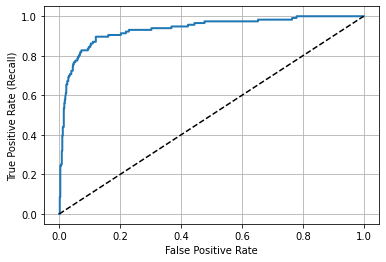

0.935
0.739
0.92
0.774
0.707


In [8]:
for months in [12, 24, 36, 48]:
    main(months)